# Analytics with Jena Climate Data
This Jupyter notebook explores Jena climate data between 2009 and 2016. After looking at some of the data, I clean the temperature data and train a recurrent neural network to predict the weather 24 hours in the future based on data 72 hours in the past.

In [1]:
import numpy as np
import matplotlib.pyplot as pp
import seaborn as sns
import datetime
import pandas as pd

In [2]:
%matplotlib inline
sns.set()
#sns.set() is going to enforce that we have the aesthetic seaborn styling on our plots.

In [3]:
data = pd.read_csv('jena_climate_2009_2016.csv')
data['Date Time'] = pd.to_datetime(data['Date Time'], format='%d.%m.%Y %H:%M:%S')

In [4]:
data.iloc[1:10]

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
1,2009-01-01 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,2009-01-01 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,2009-01-01 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,2009-01-01 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3
5,2009-01-01 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
6,2009-01-01 01:10:00,996.50,-7.62,265.81,-8.30,94.8,3.44,3.26,0.18,2.04,3.27,1305.68,0.18,0.63,166.5
7,2009-01-01 01:20:00,996.50,-7.62,265.81,-8.36,94.4,3.44,3.25,0.19,2.03,3.26,1305.69,0.19,0.50,118.6
8,2009-01-01 01:30:00,996.50,-7.91,265.52,-8.73,93.8,3.36,3.15,0.21,1.97,3.16,1307.17,0.28,0.75,188.5
9,2009-01-01 01:40:00,996.53,-8.43,264.99,-9.34,93.1,3.23,3.00,0.22,1.88,3.02,1309.85,0.59,0.88,185.0


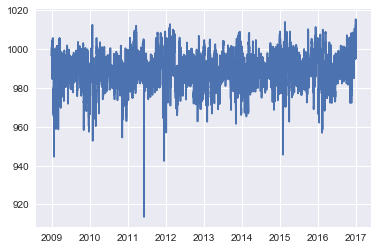

In [5]:
#Let's first look at atmospheric pressure as a function of time
pp.plot(data['Date Time'],data['p (mbar)'])

In [6]:
# We're not necessarily interested in the noisiness of the data,
# so we can compute a moving average to get a smoother average pressure.
def smoother(data_series, moving_avg_window):
    return np.correlate(data_series, np.ones(moving_avg_window)/moving_avg_window,'same')

(733261.9072916667, 736476.0996527778, 960, 1025)

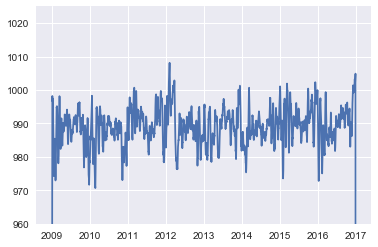

In [7]:
pp.plot(data['Date Time'],
        smoother(data['p (mbar)'],1500))
pp.axis(ymin=960,ymax=1025)
# Since the moving average runs out of points near the edges,
# the plot gets boogered up there.

In [8]:
# Let's look at the available metrics and choose some to plot together
data.columns

Index(['Date Time', 'p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)',
       'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
       'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)',
       'wd (deg)'],
      dtype='object')

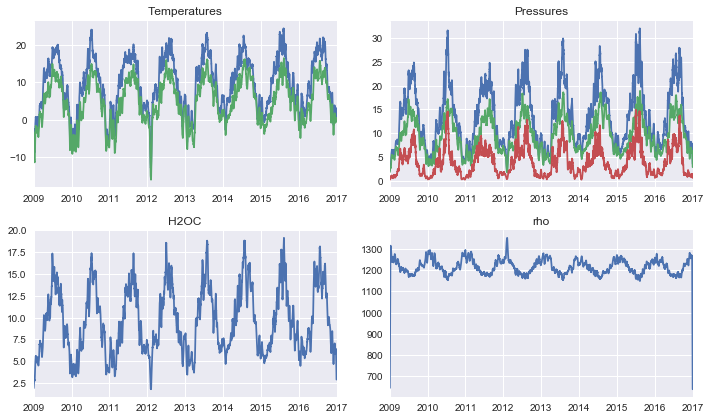

In [9]:
metrics = [['T (degC)','Tdew (degC)'],
           ['VPmax (mbar)','VPact (mbar)', 'VPdef (mbar)'],
           ['H2OC (mmol/mol)'],
           ['rho (g/m**3)']]
titles = ['Temperatures','Pressures', 'H2OC', 'rho']

pp.figure(figsize=(10,6))

for i,submetrics in enumerate(metrics):
    pp.subplot(2,2,i+1)
    
    for metric in submetrics:
        pp.plot(data['Date Time'],
                smoother(data[metric],1500))
    
    pp.title(titles[i])
    pp.axis(xmin=np.datetime64('2009'),xmax=np.datetime64('2017'))

pp.tight_layout()

In [10]:
def temperature_in_year(data,year):
    start = np.datetime64('{}'.format(year))
    end = start + np.timedelta64(1,'Y')
    
    return data[(data['Date Time'] >= start) & (data['Date Time'] < end)]['T (degC)'].values

In [15]:
#It looks like the density of air is lowest in the summer when the other metrics are at their heighest.
# Another fancy plot technique uses 'fillbetween' as below

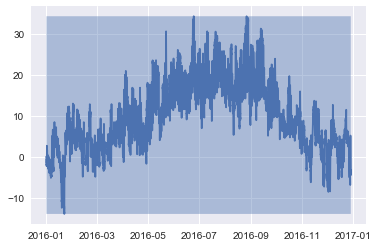

In [14]:
#Now let's plot the temperature data over a single year
T = temperature_in_year(data,2016)
#This turns out to be one measurement every 10 minutes
t=[np.datetime64('2016','Y')]
for i in range(1,len(T)):
  t.append(t[-1]+np.timedelta64(600,'s'))
t = np.array(t)

pp.fill_between(t,np.min(T,axis=0),np.max(T,axis=0),alpha=0.4)
pp.plot(t,T)


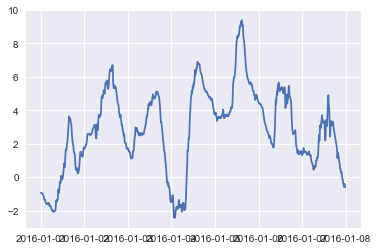

In [17]:
#What about over a single week in March?

start = np.datetime64('{}'.format('2016-03'))
end = start + np.timedelta64(7,'D')
T = data[(data['Date Time'] >= start) & (data['Date Time'] < end)]['T (degC)'].values
t=[np.datetime64('2016-03','Y')]
for i in range(1,len(T)):
  t.append(t[-1]+np.timedelta64(600,'s'))
t = np.array(t)
pp.plot(t,T)

# Preparing data for machine learning
Having looked over the data, I'm now going to normalize the temperature and pressure data and use the data from 2009-2015 to train the neural network to predict weather patterns in 2016. I will the available data from the 72 hours prior to a point in time to predict the weather 24 hours in the future. Using all of the features should be compared with a more conservative approach of using only more obvious factors, like temperature, since high dimensionality can make training very inefficient.

I begin by normalizing the data so that unit differences don't bias the training of the neural network.

In [64]:
weather_data = data[['p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)',
       'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
       'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)',
       'wd (deg)']].values

In [65]:
weather_mean = weather_data.mean(axis=0)
weather_data -= weather_mean
weather_std = weather_data.std(axis=0)
weather_data /= weather_std

# Batch Generator

In this section, I write a batch generator function to turn the input weather data into training, validation, and test data doled out in batches.

In [75]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while True:
        if shuffle:
            rows = np.random.randint(
                min_index+lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i+batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows), lookback//step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = np.arange(rows[j]-lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j]+delay][1]
        yield samples, targets

In [67]:
lookback = 432 # 72 hours worth of data used to predict the future
step = 6 # We only sample the data once every 'step' timesteps
delay = 144 # Target is 24 hours in the future
batch_size = 128
train_gen = generator(weather_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)
val_gen = generator(weather_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(weather_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

val_batches = (300000 - 200001 - lookback) // batch_size

test_batches = (len(weather_data) - 300001 - lookback) // batch_size

## Common Sense Baseline

It's a good practice to establish a common sense baseline for a correct prediction. What's a good estimate if we don't have access to neural networks or machine learning libraries? In this case, we'll compare the accuracy of our RNN model with the accuracy of assuming the temperature doesn't change from one day to the next.

In [68]:
def naive_accuracy():
    batch_maes = []
    for i in range(val_batches):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds-targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))

In [73]:
naive_accuracy()

0.30512282808756186


This mean error of 0.31 corresponds to 2.6 deg Celsius. That's the error rate to beat.

In [74]:
weather_std[1]*0.31

2.611240110667551

# Recurrent Model with Dropout in Keras

Keras supports a 'Gated recurrent unit' layer which is cheaper than a 'Long-short Term Memory' layer, but which still has greater power than a naive recurrent neural network, so we'll use that to train. 

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential() # Note that if we were to stack GRU layers, we'd need to use return_sequences=True
model.add(layers.GRU(32, dropout=0.2, recurrent_dropout=0.2, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(1)) # Sum up contributions

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                             steps_per_epoch=500,
                             epochs=10,
                             validation=val_gen,
                             validation_steps=val_steps)

# Plotting the training results

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = arange(1, len(loss)+1)
pp.plot(epochs, loss, 'bo', label='Training loss')
pp.plot(epochs, val_loss, 'b', label='Validation loss')
pp.title('Training and validation loss')
pp.legend()
pp.show()